In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import scipy as sc
import math
from typing import Callable, Tuple, List

# Langrange interpolation

In [2]:
def lagrange_polynomial(x_values:np.ndarray, y_values:np.ndarray) -> sp.Expr:
    n = len(x_values)
    x = sp.symbols('x')
    polynomial = 0
    for i in range(n):
        L = 1
        for j in range(n):
            if i != j:
                L *= (x - x_values[j])/(x_values[i] - x_values[j])
        polynomial += y_values[i] * L
    return polynomial

## Tests for Lagrange interpolation method

In [3]:
x = np.array([-1, 0, 2], np.float64)
y = np.array([4, 1, -1], np.float64)

polynomial = lagrange_polynomial(x, y)
polynomial.simplify()

0.666666666666667*x**2 - 2.33333333333333*x + 1.0

# Newton interpolation

In [4]:
def divided_difference(x_values:np.ndarray, y_values:np.ndarray) -> sp.Expr:
    n = len(x_values)
    if n == 1:
        return y_values[0]
    return (divided_difference(x_values[1:], y_values[1:]) - divided_difference(x_values[:-1], y_values[:-1]))/(x_values[-1] - x_values[0])

def newton_interpolation(x_values:np.ndarray, y_values:np.ndarray) -> sp.Expr:
    n = len(x_values)
    x = sp.symbols('x')
    polynomial = y_values[0]
    for i in range(1, n):
        L = 1
        for j in range(i):
            L *= (x - x_values[j])
        polynomial += L * divided_difference(x_values[:i+1], y_values[:i+1])
    return polynomial


# Tests for Newton interpolation

In [5]:
x = np.array([-1, 0, 2], np.float64)
y = np.array([4, 1, -1], np.float64)

polynomial = newton_interpolation(x, y)
polynomial.simplify()

0.666666666666667*x**2 - 2.33333333333333*x + 1.0

# Splines

In [6]:
class Spline:
    def __init__(self):
        self.curves = []
        
    def add_curve(self, curve : Callable[[float], float], x_lim_inf : float, x_lim_sup : float):
        left = 0
        right = len(self.curves) - 1
        while left <= right:
            mid = left + (right - left) // 2
            if self.curves[mid]['x_lim_inf'] == x_lim_inf:
                raise ValueError('A curve with the same x_lim_inf already exists')
            elif self.curves[mid]['x_lim_inf'] < x_lim_inf:
                left = mid + 1
            else:
                right = mid - 1

        self.curves.insert(left, {'curve': curve, 'x_lim_inf': x_lim_inf, 'x_lim_sup': x_lim_sup})

    def evaluate(self, x : float) -> float:
        # Find the curve that contains x by doing a binary search
        # if no such curve exists it will raise an error

        left = 0
        right = len(self.curves) - 1

        while left <= right:
            mid = left + (right - left) // 2
            if self.curves[mid]['x_lim_inf'] <= x <= self.curves[mid]['x_lim_sup']:
                # return self.curves[mid]['curve'].subs('x', x)
                return self.curves[mid]['curve'](x)
            elif self.curves[mid]['x_lim_inf'] < x:
                left = mid + 1
            else:
                right = mid - 1

        raise ValueError('No curve found for x')

In [7]:
x_values = np.array([1, 2, 5, 7], np.float64)
y_values = np.array([1, 2, 3, 25], np.float64)

n = len(x_values)

spline = Spline()

for i in range(n - 1):
    x0, x1 = x_values[i], x_values[i + 1]
    y0, y1 = y_values[i], y_values[i + 1]
    curve = lambda x, x0=x0, x1=x1, y0=y0, y1=y1: y0 + (y1 - y0)/(x1 - x0) * (x - x0)
    spline.add_curve(curve, x0, x1)

spline.evaluate(7)

25.0

In [8]:
# Based on https://github.com/scipy/scipy/blob/v1.14.0/scipy/interpolate/_cubic.py#L584-L980
def cubic_natural_curve(x: np.ndarray, y: np.ndarray) -> List[Callable[[float], float]]:
  n = len(x)
  # generate the h array with differences between adjacent x values
  h = np.diff(x)

  # generate the alpha array, it contains the values of the derivative at each point
  alpha = np.zeros(n)
  for i in range(1, n-1):
    alpha[i] = 3/h[i] * (y[i+1] - y[i]) - 3/h[i-1] * (y[i] - y[i-1])

  # solve the tridiagonal system
  l = np.zeros(n)
  u = np.zeros(n)
  z = np.zeros(n)
  l[0] = 1
  u[0] = 0
  z[0] = 0
  for i in range(1, n-1):
    l[i] = 2 * (x[i+1] - x[i-1]) - h[i-1] * u[i-1]
    u[i] = h[i] / l[i]
    z[i] = (alpha[i] - h[i-1] * z[i-1]) / l[i]
  l[n-1] = 1
  z[n-1] = 0

  # solve for the coefficients
  c = np.zeros(n)
  b = np.zeros(n)
  d = np.zeros(n)
  for j in range(n-2, -1, -1):
    c[j] = z[j] - u[j] * c[j+1]
    b[j] = (y[j+1] - y[j]) / h[j] - h[j] * (c[j+1] + 2 * c[j]) / 3
    d[j] = (c[j+1] - c[j]) / (3 * h[j])
    
  # generate the curves
  curves = []
  for i in range(n-1):
    # curve = lambda x, i=i, x_i=x[i], x_i1=x[i+1], y_i=y[i], y_i1=y[i+1], b_i=b[i], c_i=c[i], d_i=d[i]: (
    #   y_i + b_i * (x - x_i) + c_i * (x - x_i)**2 + d_i * (x - x_i)**3 if x_i <= x <= x_i1 else None
    # )
    curve = lambda x, x_i=x[i], y_i=y[i], b_i=b[i], c_i=c[i], d_i=d[i]: (
      y_i + b_i * (x - x_i) + c_i * (x - x_i)**2 + d_i * (x - x_i)**3
    )
    curves.append(curve)
  return curves


In [9]:
x_values = np.array([3, 4.5, 7, 9], np.float64)
y_values = np.array([2.5, 1.0, 2.5, 0.5], np.float64)

curves = cubic_natural_curve(x_values, y_values)

spline = Spline()

for i, curve in enumerate(curves):
    spline.add_curve(curve, x_values[i], x_values[i + 1])

spline.evaluate(5.0)

1.102889733840304

In [10]:
sc.interpolate.CubicSpline(x_values, y_values, bc_type='natural')(5.0) == spline.evaluate(5.0)

True

# Function adjustment

In [11]:
def linear_regression(x_values:np.ndarray, y_values:np.ndarray) -> Callable[[float], float]:
    x_mean = np.mean(x_values)
    y_mean = np.mean(y_values)
    x_diff = x_values - x_mean
    y_diff = y_values - y_mean
    m = np.sum(x_diff * y_diff)/np.sum(x_diff**2)
    c = y_mean - m * x_mean
    return lambda x, m=m, c=c: m * x + c

In [12]:
def exponential_regression(x_values:np.ndarray, y_values:np.ndarray, 
                          x_fun: Callable[[float], float] = lambda x: x,
                          y_fun: Callable[[float], float] = lambda y: y,
                          a_fun: Callable[[float], float] = lambda a: a, 
                          b_fun: Callable[[float], float] = lambda b: b) -> Callable[[float], float]:
    x_values = x_fun(x_values)
    y_values = y_fun(y_values)

    x_sum = np.sum(x_values)
    y_sum = np.sum(y_values)
    x_times_y_sum = np.sum(x_values * y_values)
    x_squared_sum = np.sum(x_values**2)

    a = (len(x_values) * x_times_y_sum - x_sum * y_sum)/(len(x_values) * x_squared_sum - x_sum**2)
    b = (y_sum - a * x_sum)/len(x_values)

    return (a_fun(a), b_fun(b))

In [13]:
x_values = np.array([1, 2, 3, 4], np.float64)
y_values = np.array([3, 5, 6, 8], np.float64)

identity_function = lambda x: x
a, b = exponential_regression(x_values, y_values, identity_function, np.log, identity_function, np.exp)

# y = b * exp(a * x)

y = lambda x, a=a, b=b: b * np.exp(a * x)

y(2.6)

5.344462061821694

# Exercises

# 1 - A car traveled between two cities that are 160 Km apart in 2h20min. The values below have the time and distance traveled in discrete intervals.

In [14]:
time = np.array([0, 10, 30, 60, 90, 120, 140], np.float64)
distance = np.array([0, 8, 27, 58, 100, 145, 160], np.float64)

## a) What was the approximate traveled distance by the car in the first 45 minutes considering only the first 4 points

In [15]:
l_pol = lagrange_polynomial(time[:4], distance[:4])
n_pol = newton_interpolation(time[:4], distance[:4])

l_result = l_pol.subs('x', 45)
n_result = n_pol.subs('x', 45)

# Results are the same
assert l_result - n_result < 1e-10

l_result

42.5625000000000

The results are the same, as they should be and the result is inside the interval expected

$ x \in [30; 60] $

$ y \in [27; 58] $

$ g(45) = 42.5625 $

## b) How long the car took to arrive at half the destination

To obtain the time, the values inputed for both $x$ and $y$ are inverted, the $x$ values will be the traveled distance and the $y$ values will be the time 

In [16]:
half_destination = distance[-1] / 2

l_pol = lagrange_polynomial(distance, time)
n_pol = lagrange_polynomial(distance, time)

l_result = l_pol.subs('x', half_destination)
n_result = n_pol.subs('x', half_destination)

# Results are equal within a 1/(10^10) error
assert l_result - n_result < 1e-10

n_result

77.8354988011719

The obtained result is inside the value expected. For traveling 80Km, the car took approximately 78 minutes.

# 2 - A wire has the following resistivity (Ohms) according to the lenght (m)

In [17]:
lenght = np.array([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000], np.float64)
resistivity = np.array([2.74, 5.48, 7.90, 11.00, 13.93, 16.43, 20.24, 23.52], np.float64)

Using polinommyals of degree 2 and 3, calculate the aproximation to the risistivity in with the given lenght

## a) 1730m

First using a degree 2 polinomyal using 3 points, $ [1000, 1500, 2000] $

In [18]:
l_pol = lagrange_polynomial(lenght[1:4], resistivity[1:4])
n_pol = newton_interpolation(lenght[1:4], resistivity[1:4])

l_result = l_pol.subs('x', 1730)
n_result = n_pol.subs('x', 1730)

# Results are the same
assert l_result - n_result < 1e-10

l_result

9.24154400000000

Now using the degree 3 polinomyal, using 4 points $ [500, 1000, 1500, 2000] $

In [19]:
l_pol = lagrange_polynomial(lenght[:4], resistivity[:4])
n_pol = newton_interpolation(lenght[:4], resistivity[:4])

l_result = l_pol.subs('x', 1730)
n_result = n_pol.subs('x', 1730)

# Results are the same
assert l_result - n_result < 1e-10

l_result

9.18110000000000

In both cases the result is inside the interval expected for the input value, the result should be between $[7.9; 11.0]$ as the input is between $[1500; 2000]$

## b) 3200m

Solving using the degree 2 polynomial considering the 3 points $[2500, 3000, 3500]$

In [20]:
l_pol = lagrange_polynomial(lenght[4:7], resistivity[4:7])
n_pol = newton_interpolation(lenght[4:7], resistivity[4:7])

l_result = l_pol.subs('x', 3200)
n_result = n_pol.subs('x', 3200)

# Results are the same
assert l_result - n_result < 1e-10

l_result

17.7968000000000

Result is inside the expected range for the input $[16.43;20.24]$

Now calculating using the degree 3 polynomial, considering the points $[2500, 3000, 3500, 4000]$

In [21]:
l_pol = lagrange_polynomial(lenght[4:], resistivity[4:])
n_pol = newton_interpolation(lenght[4:], resistivity[4:])

l_result = l_pol.subs('x', 3200)
n_result = n_pol.subs('x', 3200)

# Results are the same
assert l_result - n_result < 1e-10

l_result

17.8998400000000

The result found is inside the expected interval using a degree 3 polynomial to interpolate the points

# 3 - By moving trought Pelotas on a veicle, the following coordinates were obtained

In [22]:
latitude = np.array([0.4488888889, 0.4472222222, 0.4505555556, 0.4494444444], np.float64)
longitude = np.array([0.0933333333, 0.0988888889, 0.1044444444, 0.11], np.float64)

Aproximate the road by a natural cubic spline and find

## a) The latitude of the road at the longitude $ \lambda = 6' $

In [23]:
# Converting 6'00" to decimal degrees
value = 6./60.

curves = cubic_natural_curve(longitude, latitude)

spline = Spline()
for i, curve in enumerate(curves):
    spline.add_curve(curve, longitude[i], longitude[i + 1])
  
res = spline.evaluate(value)

# Convert the latitude to degrees, minutes and seconds and print the result
degrees = int(res)
minutes = int((res - degrees) * 60)
seconds = int(((res - degrees) * 60 - minutes) * 60)
print(f'{degrees}°{minutes}\'{seconds}"')

# print result in decimal degrees also
print(res)

0°26'51"
0.44771111110408535


## b) The coordinates of the road at the furthest point from the equator, supposing it happens between 6'16" and 6'36" of longitude

To find the furthest point on the road is necessary to find the highest latitude. To do so is possible to use some optimization functions, or to find the maxima of the spline in the interval given. I will be plotting the spline in the interval.

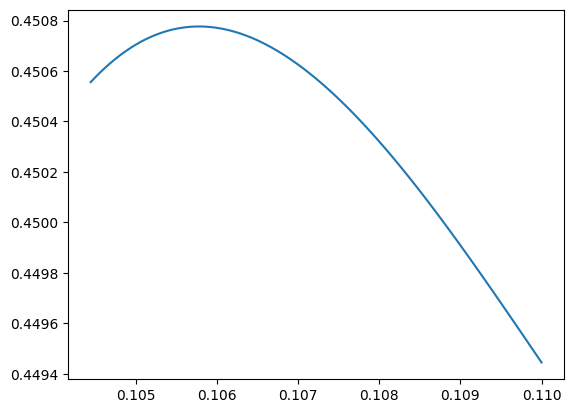

In [24]:
points = 100

interval_start = 0.1044444444
# interval_start = longitude[0]
interval_end = 0.11

x = np.linspace(interval_start, interval_end, points)
y = np.array([spline.evaluate(x_i) for x_i in x])

plt.plot(x, y)
# plt.scatter(longitude, latitude)

Just by plotting the function is possible to observe that the maximum is arround 0.105 and 0.106. To find the exact value, I will be using the scipy minimize funtion.

In [25]:
optimization_res = sc.optimize.minimize_scalar(lambda x: -spline.evaluate(x), bounds=(interval_start, interval_end), method='bounded')
print(optimization_res.x)

# print result in decimal degrees also
res = spline.evaluate(optimization_res.x)
degrees = int(res)
minutes = int((res - degrees) * 60)
seconds = int(((res - degrees) * 60 - minutes) * 60)
print(f'latitude {degrees}°{minutes}\'{seconds}"')

degrees = int(optimization_res.x)
minutes = int((optimization_res.x - degrees) * 60)
seconds = int(((optimization_res.x - degrees) * 60 - minutes) * 60)
print(f'longitude {degrees}°{minutes}\'{seconds}"')


0.10577904934195083
latitude 0°27'2"
longitude 0°6'20"


# 4 - The number of bacteria by unit of volume is given by hours 

In [26]:
hours = np.array([0, 1, 2, 3, 4, 5, 6], np.float64)
number_of_bacteria = np.array([32, 47, 65, 92, 132, 190, 275], np.float64)

## a) Make the scatter plot of the data

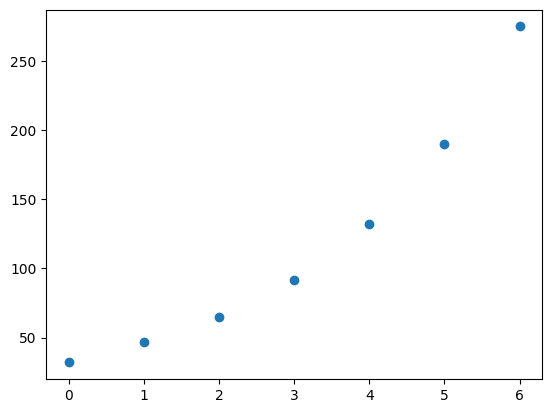

In [27]:
plt.scatter(hours, number_of_bacteria)
plt.show()

By analizing the scatter plot, the values appear to show an exponential form

## b) Use the function adjustment to adjust the curves $ y = ab^x $ and $y=ax^b$

$y = ab^x$

In [28]:
i = lambda v : v
a, b = exponential_regression(
  x_values=hours, 
  y_values=number_of_bacteria,
  x_fun=i,
  y_fun=np.log,
  a_fun=np.exp,
  b_fun=np.exp
  )

# g(x) = b * a ^ x
curve_1 = lambda x, a=a, b=b: b * np.power(a, x)

list(map(curve_1, hours))

[32.1468513163175,
 45.87223257677207,
 65.45778623455297,
 93.40556450043047,
 133.2858928100849,
 190.193478484888,
 271.3982590019799]

$ y = ax^b$

In [29]:
i = lambda v : v
a, b = exponential_regression(
  x_values=hours[1:], 
  y_values=number_of_bacteria[1:],
  x_fun=i,
  y_fun=np.log,
  a_fun=np.exp,
  b_fun=np.exp
  )

#g(x) = b * x^a
curve_2 = lambda x, a=a, b=b: b * np.power(x, a)

list(map(curve_2, hours[1:]))

[32.27466746917803,
 86.7013789563114,
 154.5507031013941,
 232.91112511398288,
 320.14760392292897,
 415.17884236468035]

To identify the best curve, I will calculate the error of each curve

In [30]:
squared_error_sum_1 = np.sum(np.square(np.diff(list(map(curve_1, hours)))))
squared_error_sum_2 = np.sum(np.square(np.diff(list(map(curve_2, hours[1:])))))

squared_error_sum_1, squared_error_sum_2

(12776.188585075255, 30347.29296299587)

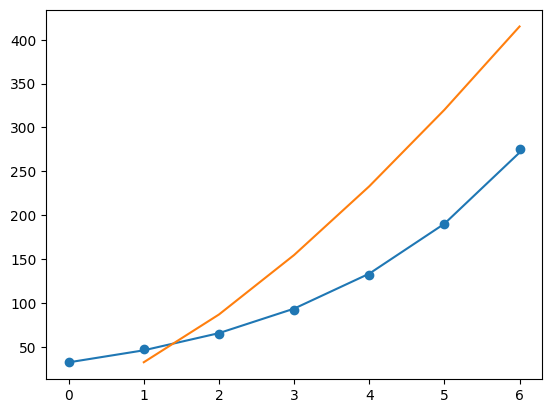

In [31]:
plt.scatter(hours, number_of_bacteria)
plt.plot(hours, list(map(curve_1, hours)))
plt.plot(hours[1:], list(map(curve_2, hours[1:])))


By calculating the square sum error for each curve, the one that fitted the best the initial values is the first curve

In [32]:
curve_1(7), curve_2(7)

(387.2741356647424, 517.2233055991059)